In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import time
# import os
# from IPython.display import clear_output # the corresponding to os.system('cls') on IPyhotn IDE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###Part A
**Data Collection**\
Paramaters of Experiment:
*   q0: 0.4 (r|y0 ~ Ber(0.4))\
*   q1: 0.6 (r|y1 ~ Ber(0.6))\


Experiment was conducted by PyCharm, as the the output's deletion methods were more comfortable there. Attached to the Moodle submission is the folder "rl_experiment" with a file "experiment.py".


###Part B
**Display Results**

In [0]:
res1 = pd.read_csv("/content/drive/My Drive/C&C/ex8/results_Eima.csv", index_col=0)
res2 = pd.read_csv("/content/drive/My Drive/C&C/ex8/results_Aba.csv", index_col=0)

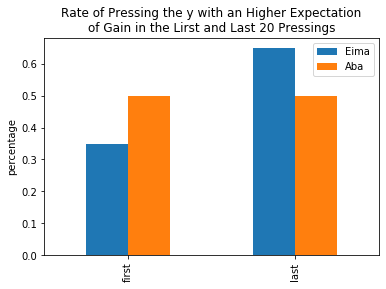

In [9]:
q0 = 0.6
q1 = 0.9

if q0<q1:
  favor = 1
else:
  favor=0

f_per1 = (res1.loc[:20,"y"] == favor).sum() / 20
f_per2 = (res2.loc[:20,"y"] == favor).sum() / 20
l_per1 = (res1.loc[80:,"y"] == favor).sum() / 20
l_per2 = (res2.loc[80:,"y"] == favor).sum() / 20

pd.DataFrame({"Eima": [f_per1,l_per1],"Aba": [f_per2,l_per2]},index=["first","last"]).plot(kind="bar")
plt.title("Rate of Pressing the y with an Higher Expectation\nof Gain in the Lirst and Last 20 Pressings")
plt.ylabel("percentage")
plt.show()

We can be impressed that Aba has almost no learning at all, while Eima imporved her results in her last trails.

###Part C

####Q1

In [0]:
# results df columns ["y","r"]
def reinforce_log_likelihood(res, eta, p1=0.5):
  results = res.copy()
  results["p"] = np.nan
  results.loc[0,"p"] = p1
  for t in range(1,results.shape[0]):
    yt, rt, pt = results.loc[t-1, ["y","r","p"]]
    results.loc[t,"p"] = pt + eta*rt*pt*(1-pt)*(yt-pt)
  return np.sum(np.log(results["p"].values))


def td_log_likelihood(res, eta, beta=2, v0=0, v1=0):
  results = res.copy()
  results["v0"], results["v1"] = np.nan, np.nan
  results.loc[0,"v0"], results.loc[0,"v1"] = v0, v1
  results["p"] = np.nan
  results.loc[0, "p"] = np.exp(beta*v1)/(np.exp(beta*v1)+np.exp(beta*v0))
  
  for t in range(1, results.shape[0]):
    yt, rt, v0t, v1t = results.loc[t-1, ["y","r","v0","v1"]]
    d_0, d_1 = int(yt==0), int(yt==1) # delta(i,yt) function
    
    results.loc[t, "v0"] = v0t + eta*d_0*(rt-v0t)
    results.loc[t, "v1"] = v1t + eta*d_1*(rt-v1t)
    v0, v1 = results.loc[t, "v0"], results.loc[t, "v1"]
    results.loc[t,"p"] = np.exp(beta*v1)/(np.exp(beta*v1)+np.exp(beta*v0))
  
  return np.sum(np.log(results["p"].values))


####Q2

In [0]:
# results df with columns ["y","r"]
def mle_eta_reinforce(res):
  results=res.copy()
  etas = np.arange(0,1.005,0.005)
  vf = np.vectorize(lambda eta: reinforce_log_likelihood(results,eta))
  log_likelihood = np.apply_along_axis(vf, axis=0, arr=etas)
  return etas[np.argmax(log_likelihood)]


def mle_eta_td(res):
  results = res.copy()
  etas = np.arange(0,1.005,0.005)
  vf = np.vectorize(lambda eta: td_log_likelihood(results,eta))
  log_likelihood = np.apply_along_axis(vf, axis=0, arr=etas)
  return etas[np.argmax(log_likelihood)]

In [0]:
opt_eta_reinforce_Eima = mle_eta_reinforce(res1)
opt_eta_reinforce_Aba = mle_eta_reinforce(res2)
opt_eta_td_Eima = mle_eta_td(res1)
opt_eta_td_Aba = mle_eta_td(res2)

Optimal Eta

In [16]:
opt_etas = pd.DataFrame({"Eima":[opt_eta_reinforce_Eima,opt_eta_td_Eima], "Aba":[opt_eta_reinforce_Aba,opt_eta_td_Aba]},
             index = ["reinforce","td"])
opt_etas

,Eima,Aba
reinforce,0.0,1.000
td,0.0,0.225


It seems that Eima doesn't learn anything, as her MLE eta is 0 in the two methods. For Aba, there is a meaningful difference between the two methods. This results of reinforcement are somewhat surprising, as the impression from the histogram of Part B was that Aba didn't learn at all, and Eima did learn the right probabilities. Perhaps the reason is that we didn't get a glimpse to the subject's results in the middle 60 trails.

####Q3

#####3.1

In [0]:
def symm(eta, model, trails=100 ,q0=0.4, q1=0.6):
  if model == "reinforce":
    results = pd.DataFrame(np.nan, index=np.arange(trails), columns=["y","r","p"])
    results.loc[0,"p"] = 0.5
    for t in range(trails):
      pt = results.loc[t,"p"]
      yt = np.random.binomial(1,pt)
      qt = q0 if yt==0 else q1
      rt = np.random.binomial(1,qt)
      results.loc[t, ["y","r"]] = yt, rt
      if t==trails-1:
        break
      results.loc[t+1, "p"] = pt + eta*rt*pt*(1-pt)*(yt-pt)
    
    return results
  
  else:
    beta=2
    results = pd.DataFrame(np.nan, index=np.arange(trails), columns=["y","r","p","v0","v1"])
    results.loc[0,"p"], results.loc[0,"v0"], results.loc[0,"v1"] = 0.5, 0, 0
    for t in range(trails):
      pt = results.loc[t,"p"]
      yt = np.random.binomial(1, pt)
      qt = q0 if yt==0 else q1
      rt = np.random.binomial(1,qt)
      results.loc[t, ["y","r"]] = yt, rt
      
      if t==trails-1:
        break
      d_0, d_1 = int(yt==0), int(yt==1) # delta(i,yt) function
      v0t, v1t = results.loc[t,"v0"], results.loc[t,"v1"]
      v0_new = v0t + eta*d_0*(rt-v0t)
      v1_new = v1t + eta*d_1*(rt-v1t)
      
      results.loc[t+1, "v0"] = v0_new
      results.loc[t+1, "v1"] = v1_new
      results.loc[t+1,"p"] = np.exp(beta*v1_new)/(np.exp(beta*v1_new)+np.exp(beta*v0_new))
    
    return results

#####3.2

In [0]:
E_R_lst = []
for i in range(100):
  res = symm(eta = opt_etas.loc["reinforce","Eima"], model="reinforce")
  eta = mle_eta_reinforce(res=res)
  E_R_lst.append(eta)

A_R_lst = []
for i in range(100):
  res = symm(eta = opt_etas.loc["reinforce","Aba"], model="reinforce")
  eta = mle_eta_reinforce(res=res)
  A_R_lst.append(eta)

E_T_lst = []
for i in range(100):
  res = symm(eta = opt_etas.loc["td","Eima"], model="td")
  eta = mle_eta_td(res=res)
  E_T_lst.append(eta)

A_T_lst = []
for i in range(100):
  res = symm(eta = opt_etas.loc["td","Aba"], model="td")
  eta = mle_eta_td(res=res)
  A_T_lst.append(eta)

As finding the optimal eta (from np.arange(0,1,0.005)) in Question 3.2 took approx 2 minutes, the process above takes 100(trails of experiment) * 2 minutes, which means more than 3 hours of running. I ran it once but couldn't try and symmulate it for more than that, the results are printed below.

#####3.3

In [134]:
print(E_R_lst)
print(E_T_lst)
print(A_R_lst)
print(A_T_lst)

[1.0, 0.0, 0.535, 1.0, 0.61, 1.0, 0.865, 1.0, 0.44, 0.63, 1.0, 0.26, 1.0, 0.91, 1.0, 1.0, 1.0, 0.0, 1.0, 0.63, 1.0, 1.0, 0.755, 1.0, 0.14, 0.48, 1.0, 0.28, 1.0, 0.485, 1.0, 0.8300000000000001, 1.0, 1.0, 1.0, 1.0, 0.73, 1.0, 0.185, 0.51, 0.32, 1.0, 0.0, 1.0, 1.0, 0.19, 1.0, 0.34500000000000003, 1.0, 1.0, 0.875, 1.0, 1.0, 0.135, 1.0, 1.0, 0.0, 1.0, 0.485, 1.0, 1.0, 0.0, 0.605, 1.0, 1.0, 0.65, 0.26, 0.2, 1.0, 1.0, 1.0, 0.0, 0.605, 1.0, 1.0, 1.0, 0.23, 0.635, 0.435, 0.5700000000000001, 0.0, 0.875, 0.35000000000000003, 1.0, 0.76, 1.0, 0.28500000000000003, 0.56, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.885, 0.49, 0.0, 0.385, 1.0, 1.0]
[0.005, 0.055, 0.05, 0.215, 0.085, 0.21, 0.15, 0.255, 0.21, 0.1, 0.1, 0.305, 0.13, 0.225, 0.26, 0.3, 0.265, 0.21, 0.12, 0.055, 0.145, 0.09, 0.25, 0.105, 0.265, 0.12, 0.06, 0.185, 0.3, 0.05, 0.27, 0.41500000000000004, 0.105, 0.075, 0.15, 0.155, 0.16, 0.13, 0.545, 0.095, 0.225, 0.28500000000000003, 0.195, 0.245, 0.065, 0.05, 0.20500000000000002, 0.20500000000000002, 0.16,

In [0]:
E_R_lst = [1.0, 0.0, 0.535, 1.0, 0.61, 1.0, 0.865, 1.0, 0.44, 0.63, 1.0, 0.26, 1.0, 0.91, 1.0, 1.0, 1.0, 0.0, 1.0, 0.63, 1.0, 1.0, 0.755, 1.0, 0.14, 0.48, 1.0, 0.28, 1.0, 0.485, 1.0, 0.8300000000000001, 1.0, 1.0, 1.0, 1.0, 0.73, 1.0, 0.185, 0.51, 0.32, 1.0, 0.0, 1.0, 1.0, 0.19, 1.0, 0.34500000000000003, 1.0, 1.0, 0.875, 1.0, 1.0, 0.135, 1.0, 1.0, 0.0, 1.0, 0.485, 1.0, 1.0, 0.0, 0.605, 1.0, 1.0, 0.65, 0.26, 0.2, 1.0, 1.0, 1.0, 0.0, 0.605, 1.0, 1.0, 1.0, 0.23, 0.635, 0.435, 0.5700000000000001, 0.0, 0.875, 0.35000000000000003, 1.0, 0.76, 1.0, 0.28500000000000003, 0.56, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.885, 0.49, 0.0, 0.385, 1.0, 1.0]
E_T_lst = [0.005, 0.055, 0.05, 0.215, 0.085, 0.21, 0.15, 0.255, 0.21, 0.1, 0.1, 0.305, 0.13, 0.225, 0.26, 0.3, 0.265, 0.21, 0.12, 0.055, 0.145, 0.09, 0.25, 0.105, 0.265, 0.12, 0.06, 0.185, 0.3, 0.05, 0.27, 0.41500000000000004, 0.105, 0.075, 0.15, 0.155, 0.16, 0.13, 0.545, 0.095, 0.225, 0.28500000000000003, 0.195, 0.245, 0.065, 0.05, 0.20500000000000002, 0.20500000000000002, 0.16, 0.14, 0.335, 0.2, 0.19, 0.135, 0.12, 0.16, 0.105, 0.135, 0.08, 0.08, 0.265, 0.125, 0.265, 0.25, 0.15, 0.135, 0.21, 0.085, 0.04, 0.195, 0.025, 0.23500000000000001, 0.23500000000000001, 0.12, 0.225, 0.22, 0.255, 0.325, 0.17500000000000002, 0.42, 0.07, 0.08, 0.34, 0.195, 0.065, 0.23500000000000001, 0.0, 0.0, 0.045, 0.27, 0.2, 0.16, 0.155, 0.16, 0.395, 0.165, 0.085, 0.155, 0.5, 0.305]
A_R_lst = [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.885, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.47500000000000003, 1.0, 0.985, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.42, 1.0, 0.935, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.075, 1.0, 0.385, 1.0, 0.51, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.93, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
A_T_lst = [0.095, 0.225, 0.185, 0.09, 0.1, 0.225, 0.18, 0.23, 0.075, 0.19, 0.22, 0.06, 0.09, 0.025, 0.28, 0.115, 0.09, 0.13, 0.095, 0.18, 0.23, 0.195, 0.07, 0.28500000000000003, 0.27, 0.08, 0.41000000000000003, 0.23500000000000001, 0.075, 0.0, 0.09, 0.105, 0.105, 0.255, 0.07, 0.065, 0.195, 0.17500000000000002, 0.13, 0.1, 0.12, 0.11, 0.09, 0.24, 0.35000000000000003, 0.095, 0.065, 0.045, 0.15, 0.295, 0.05, 0.045, 0.095, 0.16, 0.08, 0.085, 0.0, 0.065, 0.165, 0.075, 0.065, 0.225, 0.23, 0.095, 0.365, 0.19, 0.06, 0.1, 0.105, 0.095, 0.21, 0.06, 0.085, 0.17, 0.01, 0.33, 0.06, 0.08, 0.24, 0.065, 0.0, 0.095, 0.065, 0.185, 0.095, 0.075, 0.07, 0.09, 0.105, 0.215, 0.19, 0.395, 0.055, 0.065, 0.135, 0.25, 0.19, 0.125, 0.265, 0.05]

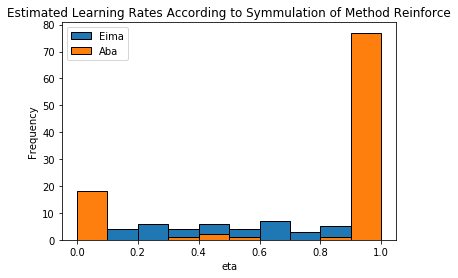

In [29]:
pd.DataFrame(np.column_stack([E_R_lst,A_R_lst]), columns=["Eima","Aba"]).plot(kind="hist", ec="k")
plt.title("Estimated Learning Rates According to Symmulation of Method Reinforce")
plt.xlabel("eta")
plt.show()

As we can see, the symmulation of the reinforce could totally differenciate between the subject's learning rates. This is compatible with the results we've got when we examine the true results of the subjects, when Eima got eta=0 and Aba got eta=1. However, we should notice the that the Eima etas are pretty uniformly distributed between 0.1 to 0.9, which put our estimation in a question mark. On the other Hand, most of Aba's etas are equal 1, corresponding the MLE estimation which conducted using his true results.

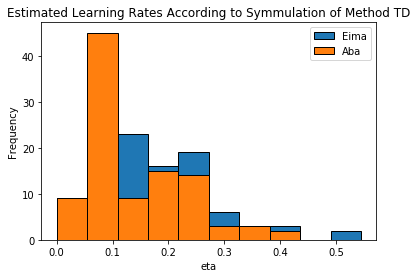

In [30]:
pd.DataFrame(np.column_stack([E_T_lst,A_T_lst]), columns=["Eima","Aba"]).plot(kind="hist", ec="k")
plt.title("Estimated Learning Rates According to Symmulation of Method TD")
plt.xlabel("eta")
plt.show()

It seems that on average the subject's rate are similar, though Aba's distribution is more concentrated. While the estimation which was based on the true value assigned to Eima 0, it's interesting to see that according to the none of the symmulations assigned her zero.

### Part D

In my opinion the reinforce is better. Firstlly, we can could see it empirically In Question 3.3, as this method were closer to the estiomation based on the real results. Moreover, the log-likelihood (P) of the TD is learned by composition of two functions: from results to the parameter V and from V to p by the sigmoid function, while The latter takes as an argument also a parameter beta. That is, we may insert another assumption to our model, which is not clearly rely on the data or other theoretical knowledge that we've already have.